In [45]:
import networkx as nx
import matplotlib.pyplot as plt

Gr = nx.DiGraph()
Gr1 = nx.DiGraph()
Gr2 = nx.DiGraph()
with open('Datasets/1992to1994.txt', 'r') as f:
    lines = f.readlines()
with open('Datasets/1992to1996.txt', 'r') as f:
    lines1 = f.readlines()
with open('Datasets/1992to2000.txt', 'r') as f:
    lines2 = f.readlines()
edges = []
count = 0

for line in lines:
    if count < 4:
        count += 1
    else:
        linesp = line.strip().split()
        edges.append((int(linesp[0]), int(linesp[1])))
        count+=1

Gr.add_edges_from(edges)
edges = []
count = 0

for line in lines1:
    if count < 4:
        count += 1
    else:
        linesp = line.strip().split()
        edges.append((int(linesp[0]), int(linesp[1])))
        count+=1
Gr1.add_edges_from(edges)
edges = []
count = 0

for line in lines2:
    if count < 4:
        count += 1
    else:
        linesp = line.strip().split()
        edges.append((int(linesp[0]), int(linesp[1])))
        count+=1
Gr2.add_edges_from(edges)
labels=nx.clustering(Gr)
labels1=nx.clustering(Gr1)
labels2=nx.clustering(Gr2)
print(labels)
print(labels1)
print(labels2)

{9403384: 0.017857142857142856, 9302210: 0.015300546448087432, 9303225: 0.019230769230769232, 9307318: 0, 9308272: 0.027777777777777776, 9310311: 0.047619047619047616, 9301212: 0.14285714285714285, 9209291: 0.06666666666666667, 9405274: 0, 9304219: 0, 9406205: 0.011029411764705883, 9203215: 0.14285714285714285, 9206222: 0.05555555555555555, 9207258: 0, 9211223: 0.1527777777777778, 9212229: 0.02813852813852814, 9212268: 0.16363636363636364, 9304230: 0.13333333333333333, 9304240: 0.01838235294117647, 9306256: 0.016339869281045753, 9306265: 0.1, 9306306: 0, 9308254: 0, 9308343: 0, 9309228: 0, 9309322: 0, 9403398: 0.04779411764705882, 9207221: 0.00641025641025641, 9209285: 0.05526315789473684, 9211240: 0.05, 9301267: 0.02813852813852814, 9301286: 0, 9301289: 0.1111111111111111, 9301290: 0.17777777777777778, 9302221: 0.054945054945054944, 9303320: 0.028409090909090908, 9304312: 0.5, 9304321: 0.12222222222222222, 9307295: 0.2222222222222222, 9308258: 0.08928571428571429, 9308318: 0.076923076

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import torch
import torch.optim as optim

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [47]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(pyg_nn.GCNConv(input_dim,hidden_dim))
        self.layerns = nn.ModuleList()
        for i in range(5):
            self.layerns.append(nn.LayerNorm(hidden_dim))
        for l in range(5):
            self.convs.append(pyg_nn.GCNConv(hidden_dim, hidden_dim))
        self.num_layers = 6 

    def forward(self, data):
        # print(data)
        x, edge_index= data.x, data.edge_index
        x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)   
            x = F.dropout(x, training=self.training)
            if not i == self.num_layers - 1:
                x = self.layerns[i](x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [48]:
def train(dataset, task):
    loader = dataset
    model = GNNStack(1, 101, 7, task=task)   # input dim should be set to 1
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    for epoch in range(300):
        total_loss = 0
        model.train()
        # count=0
        for batch in loader:
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)   
            loss.backward()
            opt.step()
            total_loss += loss.item()
        total_loss /= len(loader)

        if epoch % 10 == 0:
            model.eval()
            correct = 0
            for data in loader:
                with torch.no_grad():
                    emb, pred = model(data)
                    pred = pred.argmax(dim=1)
                    label = data.y
                mask = data.val_mask if False else data.test_mask
                pred = pred[mask]
                label = data.y[mask]
                correct += pred.eq(label).sum().item()
            
            total = 0
            for data in loader:
                    total += torch.sum(data.test_mask).item()
            print("Epoch {}. Loss: {:.4f}. Accuracy:{:.4f}. ".format(
                epoch, total_loss, correct / total))
            
    return model


In [49]:
task = 'node'
pyGraph=pyg_utils.convert.from_networkx(Gr)
pyGraph.x=torch.ones(pyGraph.num_nodes,1)
labs=[]
for j in Gr.nodes:
    labs.append(labels[j])
# print(labs)
pyGraph.y=torch.tensor(labs)
import random
train_mask = [random.random() > 0.9 for _ in range(pyGraph.num_nodes)]
test_mask = [not x for x in train_mask]
pyGraph.train_mask = torch.tensor(train_mask)
pyGraph.test_mask = torch.tensor(test_mask)
# pyGraph.val_mas/k = torch.tensor(test_mask)
# print(pyGraph.y)
for i in range(pyGraph.num_nodes):
    pyGraph.y[i]=int(pyGraph.y[i]*100)
pyGraph.y=pyGraph.y.type(torch.LongTensor)
# -----------------------------------------------------------------
pyGraph1=pyg_utils.convert.from_networkx(Gr1)
pyGraph1.x=torch.ones(pyGraph1.num_nodes,1)
labs=[]
for j in Gr1.nodes:
    labs.append(labels1[j])
# print(labs)
pyGraph1.y=torch.tensor(labs)
import random
train_mask = [random.random() > 0.6 for _ in range(pyGraph1.num_nodes)]
test_mask = [not x for x in train_mask]
pyGraph1.train_mask = torch.tensor(train_mask)
pyGraph1.test_mask = torch.tensor(test_mask)
# pyGraph.val_mas/k = torch.tensor(test_mask)
# print(pyGraph1.y)
for i in range(pyGraph1.num_nodes):
    pyGraph1.y[i]=int(pyGraph1.y[i]*100)
pyGraph1.y=pyGraph1.y.type(torch.LongTensor)
# -----------------------------------------------------------------
pyGraph2=pyg_utils.convert.from_networkx(Gr2)
pyGraph2.x=torch.ones(pyGraph2.num_nodes,1)
labs=[]
for j in Gr2.nodes:
    labs.append(labels2[j])
# print(labs)
pyGraph2.y=torch.tensor(labs)
import random
train_mask = [random.random() > 0.0001 for _ in range(pyGraph2.num_nodes)]
test_mask = [not x for x in train_mask]
pyGraph2.train_mask = torch.tensor(train_mask)
pyGraph2.test_mask = torch.tensor(test_mask)
for i in range(pyGraph2.num_nodes):
    pyGraph2.y[i]=int(pyGraph2.y[i]*100)
pyGraph2.y=pyGraph2.y.type(torch.LongTensor)
dataset=[]
# dataset.append(pyGraph)
dataset.append(pyGraph1)
dataset.append(pyGraph2)
model = train(dataset, task)

Epoch 0. Loss: 5.0745. Accuracy:0.0407. 
Epoch 10. Loss: 4.4580. Accuracy:0.0449. 
Epoch 20. Loss: 4.3290. Accuracy:0.0359. 
Epoch 30. Loss: 4.3031. Accuracy:0.0523. 
Epoch 40. Loss: 4.2652. Accuracy:0.0552. 
Epoch 50. Loss: 4.2410. Accuracy:0.0457. 
Epoch 60. Loss: 4.2410. Accuracy:0.0629. 
Epoch 70. Loss: 4.2190. Accuracy:0.0704. 
Epoch 80. Loss: 4.1891. Accuracy:0.0553. 
Epoch 90. Loss: 4.1965. Accuracy:0.0770. 
Epoch 100. Loss: 4.1916. Accuracy:0.1832. 
Epoch 110. Loss: 4.1842. Accuracy:0.1837. 
Epoch 120. Loss: 4.1744. Accuracy:0.1901. 
Epoch 130. Loss: 4.1470. Accuracy:0.1893. 
Epoch 140. Loss: 4.1592. Accuracy:0.2199. 
Epoch 150. Loss: 4.1416. Accuracy:0.2183. 
Epoch 160. Loss: 4.1565. Accuracy:0.2194. 
Epoch 170. Loss: 4.1177. Accuracy:0.2151. 
Epoch 180. Loss: 4.1272. Accuracy:0.2231. 
Epoch 190. Loss: 4.1340. Accuracy:0.2224. 
Epoch 200. Loss: 4.1328. Accuracy:0.2241. 
Epoch 210. Loss: 4.1488. Accuracy:0.2211. 
Epoch 220. Loss: 4.1342. Accuracy:0.2211. 
Epoch 230. Loss: 4.100

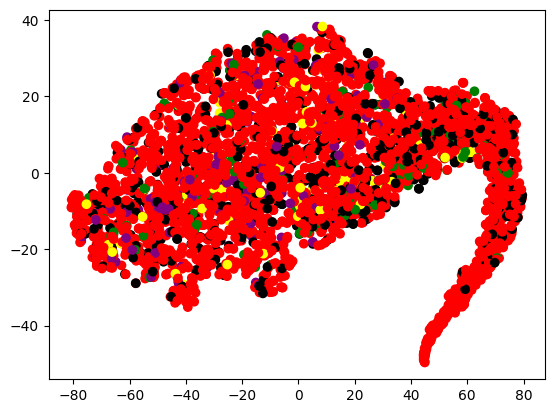

In [50]:
color_list = ["red", "black", "green", "yellow", "purple", "brown", "pink", "gray", "olive", "cyan"]

num_colors = len(color_list)
color_step = 101 / num_colors
dataset.append(pyGraph)
loader = dataset
embs = []
colors = []

# for batch in loader:.
emb, pred = model(loader[2])
embs.append(emb)
normalized_y = torch.clamp(loader[2].y, 0, 101)
colors += [color_list[int(y // color_step)] for y in normalized_y]

embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)
plt.show()
